In [1]:
import csv
import gzip
import os
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData, Dataset10X
from scvi.models import VAE, TOTALVI, LDVAE
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer


import umap
import anndata
import scanpy as sc
import umap


save_path = "../../data/10X"
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
dataset = Dataset10X(
    dataset_name="293t",
    save_path=save_path,
    measurement_names_column=1,
    dense=True,
)

[2020-01-31 15:56:29,052] INFO - scvi.dataset.dataset | File /data/yosef2/users/adamgayoso/software/scVI/data/10X/293t/filtered_gene_bc_matrices.tar.gz already downloaded
[2020-01-31 15:56:29,053] INFO - scvi.dataset.dataset10X | Preprocessing dataset
[2020-01-31 15:56:29,057] INFO - scvi.dataset.dataset10X | Extracting tar file
[2020-01-31 15:56:48,310] INFO - scvi.dataset.dataset10X | Finished preprocessing dataset
[2020-01-31 15:56:48,637] WARNING - scvi.dataset.dataset | Gene names are not unique.
[2020-01-31 15:56:48,639] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-31 15:56:48,641] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-01-31 15:56:51,812] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-31 15:56:51,960] INFO - scvi.dataset.dataset | Downsampled from 2885 to 2885 cells


In [3]:
expressed_genes = np.mean(dataset.X > 0, axis=0) > 0.1
dataset.update_genes(expressed_genes)
non_mt = np.array(["MT-" not in g for g in dataset.gene_names]).astype(bool)
dataset.update_genes(non_mt)
dataset.update_cells((dataset.X > 0).sum(1) > 500)

[2020-01-31 15:56:52,322] INFO - scvi.dataset.dataset | Downsampling from 32738 to 7545 genes
[2020-01-31 15:56:52,942] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-31 15:56:53,009] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-01-31 15:56:53,605] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-31 15:56:53,642] INFO - scvi.dataset.dataset | Downsampled from 2885 to 2885 cells
[2020-01-31 15:56:53,648] INFO - scvi.dataset.dataset | Downsampling from 7545 to 7533 genes
[2020-01-31 15:56:54,233] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-31 15:56:54,300] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-01-31 15:56:54,896] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-31 15:56:54,932] INFO - scvi.dataset.dataset | Downsampled from 2885 to 2885 cells
[2020-01-31 15:56:55,517] INFO - scvi.dataset.dataset

In [4]:
gene_means = dataset.X.mean(0)
lib_size = np.random.uniform(0.9, 1.1, size=(5000,1))
new_X_mean = lib_size * gene_means
new_X = np.random.poisson(new_X_mean)

expressed_genes = np.mean(new_X > 0, axis=0) > 0.1
new_X = new_X[:, expressed_genes]
expressed_cells = (new_X > 0).sum(1) > 500
new_X = new_X[expressed_cells]

In [5]:
new_data = GeneExpressionDataset()
new_data.populate_from_data(new_X)

[2020-01-31 15:56:59,183] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-31 15:56:59,185] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


In [49]:
new_data = dataset

In [80]:
ldvae_vae = LDVAE(new_data.nb_genes, reconstruction_loss="nb", latent_distribution="ln", n_latent=10)
ldvae_trainer = UnsupervisedTrainer(
    ldvae_vae,
    new_data,
    train_size=1.0,
#     test_size=0.10,
    use_cuda=True,
    frequency=1,
    n_epochs_kl_warmup=150
)


In [94]:
scvi_vae = VAE(new_data.nb_genes, 
               reconstruction_loss="nb", 
               latent_distribution="normal",
              )
scvi_trainer = UnsupervisedTrainer(
    scvi_vae,
    new_data,
    train_size=1.0,
#     test_size=0.10,
    use_cuda=True,
    frequency=1,
    n_epochs_kl_warmup=150,
)

In [81]:
ldvae_trainer.train(lr=1e-3, n_epochs=300)

In [95]:
scvi_trainer.train(lr=1e-3, n_epochs=300)

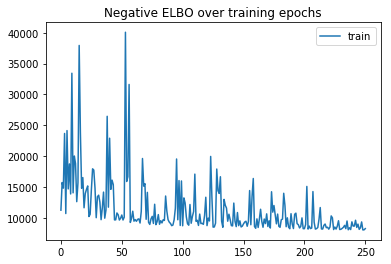

In [96]:
plt.plot(ldvae_trainer.history["elbo_train_set"][50:], label="train")
plt.title("Negative ELBO over training epochs")
plt.legend()

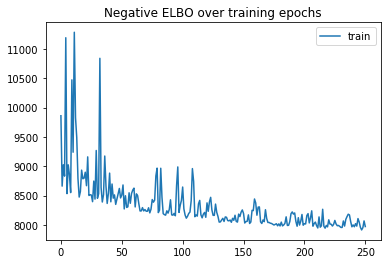

In [97]:
plt.plot(scvi_trainer.history["elbo_train_set"][50:], label="train")
plt.title("Negative ELBO over training epochs")
plt.legend()



In [103]:
full_scvi_posterior = scvi_trainer.create_posterior(
    scvi_vae, new_data, indices=np.arange(len(new_data)),
)
latent_scvi, _, _ = full_scvi_posterior.sequential().get_latent()
imputed_scvi = full_scvi_posterior.sequential().get_sample_scale()

full_ldvae_posterior = ldvae_trainer.create_posterior(
    ldvae_vae, new_data, indices=np.arange(len(new_data)),
)
latent_ldvae, _, _ = full_ldvae_posterior.sequential().get_latent()
imputed_ldvae = full_ldvae_posterior.sequential().get_sample_scale()

In [104]:
from sklearn.decomposition import PCA

pcs = PCA(n_components=2).fit_transform(latent_scvi)
pc_imputed = PCA(n_components=2).fit_transform(np.log(imputed_scvi))

In [105]:
lib_size = new_data.X.sum(1)

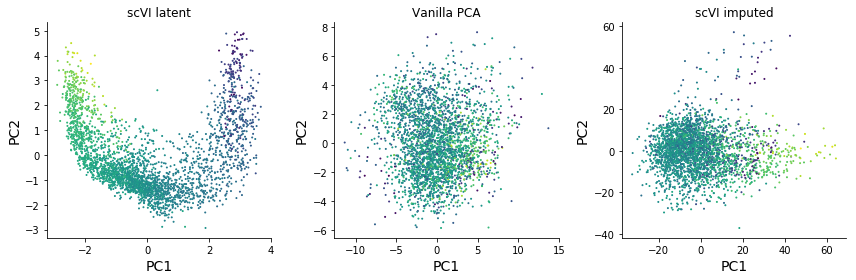

In [106]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].scatter(pcs[:, 0], pcs[:, 1], s=1, c=np.log(lib_size.ravel()))

new_data.normalize()
pcs_new = PCA(n_components=2).fit_transform(np.log(1 + new_data.norm_X))

ax[1].scatter(pcs_new[:, 0], pcs_new[:, 1], s=1, c=np.log(lib_size.ravel()))

ax[2].scatter(pc_imputed[:, 0], pc_imputed[:, 1], s=1, c=np.log(lib_size.ravel()))


ax[0].set_title("scVI latent")
ax[1].set_title("Vanilla PCA")
ax[2].set_title("scVI imputed")

sns.despine()
ax[0].set_ylabel("PC2", fontsize=14)
ax[0].set_xlabel("PC1", fontsize=14)
ax[1].set_ylabel("PC2", fontsize=14)
ax[1].set_xlabel("PC1", fontsize=14)
ax[2].set_ylabel("PC2", fontsize=14)
ax[2].set_xlabel("PC1", fontsize=14)
# plt.suptitle("scVI", fontsize=14)
# plt.subplots_adjust(top=0.85)
plt.tight_layout()

In [107]:
pcs = PCA(n_components=2).fit_transform(latent_ldvae)
pc_imputed = PCA(n_components=2).fit_transform(np.log(imputed_ldvae))

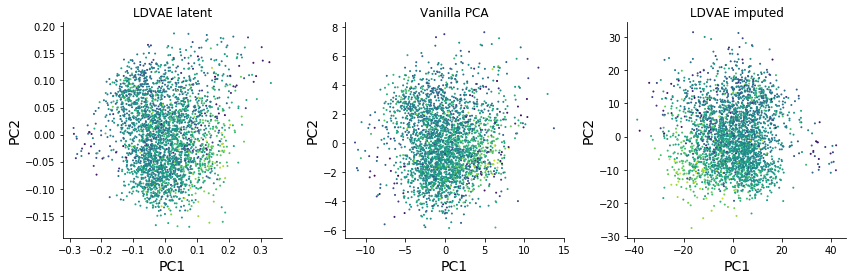

In [108]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].scatter(pcs[:, 0], pcs[:, 1], s=1, c=np.log(lib_size.ravel()))

new_data.normalize()
pcs_new = PCA(n_components=2).fit_transform(np.log(1 + new_data.norm_X))

ax[1].scatter(pcs_new[:, 0], pcs_new[:, 1], s=1, c=np.log(lib_size.ravel()))

ax[2].scatter(pc_imputed[:, 0], pc_imputed[:, 1], s=1, c=np.log(lib_size.ravel()))


ax[0].set_title("LDVAE latent")
ax[1].set_title("Vanilla PCA")
ax[2].set_title("LDVAE imputed")

sns.despine()
ax[0].set_ylabel("PC2", fontsize=14)
ax[0].set_xlabel("PC1", fontsize=14)
ax[1].set_ylabel("PC2", fontsize=14)
ax[1].set_xlabel("PC1", fontsize=14)
ax[2].set_ylabel("PC2", fontsize=14)
ax[2].set_xlabel("PC1", fontsize=14)
# plt.suptitle("scVI", fontsize=14)
# plt.subplots_adjust(top=0.85)
plt.tight_layout()

In [109]:
# fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

# ax[0].scatter(pcs[:, 0], pcs[:, 1], s=1, c=np.log(dataset.X.sum(axis=1).ravel()))
# ax[0].set_title("Log library size")

# gene = "TOP2A"
# ax[1].set_title(gene)
# gene_c = np.log(1 + dataset.X[:, dataset.gene_names == gene].ravel())
# ax[1].scatter(pcs[:, 0], pcs[:, 1], s=1, c=gene_c)


# gene = "SMC4"
# ax[2].set_title(gene)
# gene_c = np.log(1 + dataset.X[:, dataset.gene_names == gene].ravel())
# ax[2].scatter(pcs[:, 0], pcs[:, 1], s=1, c=gene_c)

# sns.despine()
# ax[0].set_ylabel("PC2", fontsize=14)
# ax[1].set_xlabel("PC1", fontsize=14)
# plt.suptitle("scVI", fontsize=14)
# plt.subplots_adjust(top=0.85)
# # plt.tight_layout()